## GNN Explainer

Here we visualize the explainer results and analyze specific graph theoretic properties for datatset `syn5`

In [1]:
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import math

In [2]:
logdir = '../log/'
# Here all the required .npy files are directly under log
expdir = ''

In [3]:
# Load produced masks
dirs = os.listdir(os.path.join(logdir, expdir))
dirs

['cora_base_h20_o20',
 'enron_base_h20_o20',
 'grad',
 'graph',
 'mask',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_400graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_405graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_410graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_415graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_420graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_425graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_430graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_435graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_440graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_445graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_450graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_455graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20_explainnode_idx_460graph_idx_-1.npy',
 'masked_adj_syn1_base_h20_o20

In [4]:
masks = []

# This would print all the files and directories
for file in dirs:
    # Check if file extension is ".npy" which are
    # numpy binary files to represent large data
    if file.split('.')[-1] == 'npy' and file.split('_')[2] == 'syn5':
        # print(file)
        masks.append(file)
len(masks)

60

In [5]:
def show_adjacency_full(mask, ax=None):
    """Plot full adjacency matrix of the mask

    Args:
        mask (str): Filename containing the adjacency matrix of the mask
        ax (Axes class object, optional): Axis. Defaults to None.

    Returns:
        numpy matrix: Full adjacency matrix of the mask
    """
    # Obtain adjacency matrix from the filename sent in var "mask"
    adj = np.load(os.path.join(logdir, expdir, mask), allow_pickle=True)
    # if ax is None:
    #     plt.figure()
    #     plt.imshow(adj);
    # else:
    #     ax.imshow(adj)
    return adj

In [6]:
def filter_adj(adj,threshold=0.8):
    """Filter out the values in adjacency matrix that are greater than threshold. Fix the others as 0

    Args:
        adj (numpy matrix): Adjacency matrix of mask that we have to filter
        threshold (float): Filter value

    Returns:
        numpy matrix: Filtered adjacency matrix
    """
    filt_adj = adj.copy()
    filt_adj[adj<threshold] = 0
    return filt_adj

### Analyzing Graph theoretic properties of each mask

Here we measure the following quantities:
- Nodes: |V|
- Edges: |E|
- Avg degree
- Diameter of the graph
- Sparsity measure: edge density = |E|/C(|V|,2)
- Node centrality measure: Betweenness centrality

In [7]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def normalize(A):
    """Min-max scaling for the matrix

    Args:
        A (np.ndarray): Matrix to normalize

    Returns:
        np.ndarray: Normalized matrix
    """
    scale_factor = A.max() - A.min()
    B = np.ones_like(A)*A.min()

    A = (A - B)/scale_factor
    return A

def centrality(adj,node,original):
    """Calculate the coherence by comparing node (edge) importance score, assigned
     by explanation method, with node (edge) betweeness centrality scores

    Args:
        adj (np.ndarray): Importance scores matrix for the mask
        node (int): Node index that is being explained in mask
        original (int): Node index that is being explained in origin syn5 graph

    Returns:
        float: coherence value
    """
    # Get the unweighted adjacency matrix
    adj1 = adj.copy()
    adj1[adj>0] = 1

    # Get the unweighted graph
    unweighted_G = nx.from_numpy_matrix(np.matrix(adj1))

    sources = [node]
    targets = [v for  v in list(unweighted_G.nodes()) if v != node]
    ebc = nx.edge_betweenness_centrality_subset(unweighted_G,sources,targets)

    # Coherence from edge mask
    # Create a symmetric matrix A with A[i][j] is the betweeness score of edge (i,j)
    A = np.zeros_like(adj1)
    v = unweighted_G.number_of_nodes()
    for i in range(v):
        for j in range(i):
            if (j,i) in ebc.keys():
                # The keys in ebc are (a,b) with a < b
                A[i][j] = A[j][i] = ebc[(j,i)]
    
    # Now that we have got A, we see if the importance given by GNNExplainer
    # has some relation with the centrality scores in A
    A1 = normalize(A)
    B1 = normalize(adj)

    # For coherence check the following two links:
    # 1) https://www.geeksforgeeks.org/cosine-similarity-calculation-between-two-matrices-in-matlab/
    # 2) https://math.stackexchange.com/questions/507742/distance-similarity-between-two-matrices#:~:text=If%20we%20have%20two%20matrices,squares%20of%20all%20singular%20values.
    
    # a = np.linalg.norm(A1,2)
    # b = np.linalg.norm(B1,2)
    # c = (abs(a - b))**2
    # d = (np.linalg.norm(A1 - B1, 2)**2)

    a = (np.linalg.norm(A1 - B1, 2)**2)

    coh = 2/(1 + math.exp(a))

    # Save the arrays A1 and B1
    folder = "D:\D_Drive\Github\Thesis\GNNExplainer_graph_properties\graph_theoretic_properties\centrality_matrices\syn5"
    file_name = str(original) + "_" + str(node) + ".npz"
    path = os.path.join(folder,file_name)
    np.savez(path,array1=A1,array2=B1)

    return coh

    # if(np.array_equal(A1,B1) == False):
    #     return c/d
    # else:
    #     return 1

def graph_prop(adj,node,original):
    # Edge weighted graph
    weighted_G = nx.from_numpy_matrix(np.matrix(adj))

    v = weighted_G.number_of_nodes()
    e = weighted_G.number_of_edges()
    avg_degree = float('%.3f'%(2*e/v))
    diameter = nx.diameter(weighted_G)
    sparsity = float('%.3f'%(1 - (2*e/(v*(v-1)))))
    # coh_node, coh_edge = float('%.3f'%(centrality_edge(adj,node,variation)))
    coh = centrality(adj,node,original)

    return [v,e,avg_degree,diameter,sparsity,coh]

In [10]:
def test(M, T):
    return [[i, j] for i, row in enumerate(M) for j, n in enumerate(row) if n == T]

def find_node_to_explain(adj):
    """Trying to get the index of the node being explained
    Logic: In the edge mask, the edges connected to the explained node will have the highest of importance
    So we can first fetch the maximum value in the masked adjacency matrix and then one of the two nodes is going to be the one explained.
    In the masked adjacency, the row/column correspoding to the explained node will have the highest of values"""

    # Obtain the positions of the maximum element in the masked adjacency matrix
    # Since matrix is symmetric we will have two positions [[a,b], [b,a]]. So we take only the first one
    pos = test(adj, adj.max())[0]

    # We obtain the two rows corresponding to indices a and b
    vec1 = adj[pos[0]]
    vec1 = vec1[vec1 > 0]
    vec2 = adj[pos[1]]
    vec2 = vec2[vec2 > 0]

    # The row of the explained node will either have more non-zero values
    if len(vec1) != len(vec2):
        return pos[np.argmax(np.array([len(vec1), len(vec2)]))]
    # Or the row of the explained node will have a larger norm due to higher values
    else:
        return pos[np.argmax(np.array([np.linalg.norm(np.array(vec1)), np.linalg.norm(np.array(vec2))]))]
data1 = []

for m in masks:
    # Get the node to explain
    original_index = m.split('.')[0].split("_")[-3].split('graph')[0]
    adj = show_adjacency_full(m)    # Full adjacency matrix
    node_to_explain = find_node_to_explain(adj)
    # print(f'mask: {original_index}, Size: {adj.shape}, Node: {node_to_explain}')
    print(f'Processing node {original_index} in syn5')
    
    # Get the metrics of each mask
    data1.append(graph_prop(adj,node_to_explain,original_index))

Processing node 400 in syn5
Processing node 405 in syn5
Processing node 410 in syn5
Processing node 415 in syn5
Processing node 420 in syn5
Processing node 425 in syn5
Processing node 430 in syn5
Processing node 435 in syn5
Processing node 440 in syn5
Processing node 445 in syn5
Processing node 450 in syn5
Processing node 455 in syn5
Processing node 460 in syn5
Processing node 465 in syn5
Processing node 470 in syn5
Processing node 475 in syn5
Processing node 480 in syn5
Processing node 485 in syn5
Processing node 490 in syn5
Processing node 495 in syn5
Processing node 500 in syn5
Processing node 505 in syn5
Processing node 510 in syn5
Processing node 515 in syn5
Processing node 520 in syn5
Processing node 525 in syn5
Processing node 530 in syn5
Processing node 535 in syn5
Processing node 540 in syn5
Processing node 545 in syn5
Processing node 550 in syn5
Processing node 555 in syn5
Processing node 560 in syn5
Processing node 565 in syn5
Processing node 570 in syn5
Processing node 575 

In [11]:
import pandas as pd

# Convert the above data into a data frame
df1 = pd.DataFrame(data1, columns=["Order","Size","Average Degree","Diameter","Sparsity","Coherence"])

df1.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,15.783333,17.366667,2.168150,5.250000,0.824100,0.165451
std,7.216017,8.447177,0.267956,0.985058,0.071899,0.188017
min,6.000000,5.000000,1.667000,3.000000,0.667000,0.004418
25%,10.750000,12.000000,1.891750,4.000000,0.773000,0.013908
50%,15.000000,16.000000,2.273500,6.000000,0.844000,0.064308
75%,18.250000,21.000000,2.390250,6.000000,0.879750,0.278876
max,43.000000,46.000000,2.600000,6.000000,0.949000,0.606880


In [12]:
df1.to_csv("syn5_latest.csv")

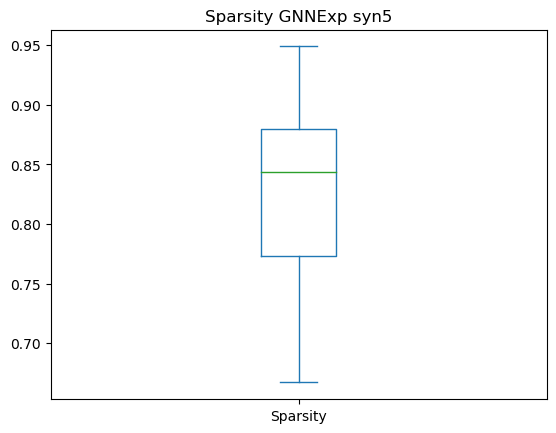

In [15]:
# Plot Sparsity
plt.figure()
df1['Sparsity'].plot(kind='box')
# plt.savefig(fname= "D:\D_Drive\Github\Thesis\GNNExplainer_graph_properties\graph_theoretic_properties\syn5_sparsity_box")
plt.title("Sparsity GNNExp syn5")
plt.show()

In [22]:
norms = []
path = "D:\D_Drive\Github\Thesis\GNNExplainer_graph_properties\graph_theoretic_properties\centrality_matrices\syn5"
for m in list(os.listdir(path)):
    mats = np.load(os.path.join(path,m))
    A,B=mats['array1'],mats['array2']
    norms.append({'A':np.linalg.norm(A,'fro'),'B':np.linalg.norm(B,'fro')})

df_norms = pd.DataFrame(norms)

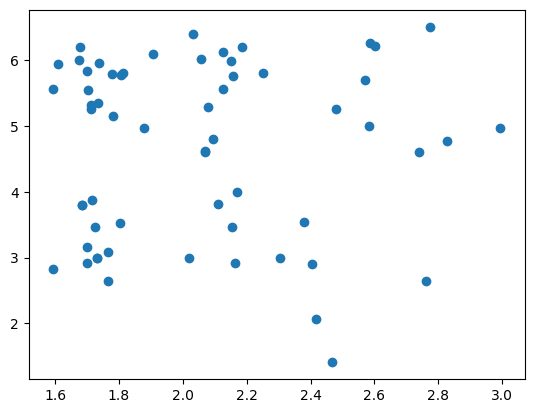

In [24]:
plt.scatter(df_norms['A'].values,df_norms['B'].values)